## Import modules and load symbol meta

In [1]:
import os
import shutil
from tqdm import tqdm
from fxqu4nt.settings import get_all_q_script_paths, get_all_q_utils_paths
from fxqu4nt.utils.csv_tick_file import parallel_split_by_month, parallel_fix_date, head
from fxqu4nt.utils.common import get_tmp_dir
from fxqu4nt.market.symbol import Symbol
from fxqu4nt.market.kdb import get_db

kdb = get_db()
kdb.restore_all()
for sp in get_all_q_utils_paths():
    kdb.load_script(sp)
for sp in get_all_q_script_paths():
    kdb.load_script(sp)
symbol_meta = kdb.get_symbols()
symbol_meta

/Users/asm/blog/_research/fxqu4nt/fxqu4nt/settings.py:49: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  gmcnf = yaml.load(fobj)
2020-05-28T17:02:05 - QuotesDB - INFO - Connected to kdb+ server. IPC version: 3
2020-05-28T17:02:05 - QuotesDB - INFO - Restore SymMeta table
2020-05-28T17:02:05 - QuotesDB - DEBUG - Execute query: SymMeta:(get `:/Users/asm/fx/SymMeta.dat)
2020-05-28T17:02:05 - QuotesDB - INFO - Load script /Users/asm/blog/_research/fxqu4nt/fxqu4nt/q/utils/common.q to kdb
2020-05-28T17:02:05 - QuotesDB - DEBUG - Execute query: \l /Users/asm/blog/_research/fxqu4nt/fxqu4nt/q/utils/common.q
2020-05-28T17:02:05 - QuotesDB - INFO - Load script /Users/asm/blog/_research/fxqu4nt/fxqu4nt/q/utils/dbmaint.q to kdb
2020-05-28T17:02:05 - QuotesDB - DEBUG - Execute query: \l /Users/asm/blog/_research/fxqu4nt/fxqu4nt/q/utils/dbmaint.q
2020-05-28T17:02:05 - QuotesDB - INFO -

,point,min_vol,max_vol,vol_step
name,,,,
EURUSD,0.00001,0.01,10000.0,0.01


## Drop symbols

In [3]:
kdb.remove_symbol("EURUSD")
kdb.remove_symbol_quotes("EURUSD")
symbol_meta = kdb.get_symbols()
symbol_meta

2020-05-28T15:38:07 - QuotesDB - DEBUG - Execute query: delete from `SymMeta where name=`EURUSD
2020-05-28T15:38:07 - QuotesDB - DEBUG - Execute query: `:/Users/asm/fx/SymMeta.dat set SymMeta


,point,min_vol,max_vol,vol_step
name,,,,


## Declare symbols

In [4]:
eurusd_symbol = Symbol(name="EURUSD", point=0.00001, min_vol=0.01, max_vol=10000, vol_step=0.01)

## Add symbol

In [5]:
kdb.add_symbol(eurusd_symbol)
symbol_meta = kdb.get_symbols()
symbol_meta

2020-05-28T15:38:11 - QuotesDB - DEBUG - Execute query: `SymMeta insert (`EURUSD;0.0000100;0.0100000;10000.0000000;0.0100000)
2020-05-28T15:38:11 - QuotesDB - INFO - Symbol added with settings:[name=EURUSD, point=1e-05, min_vol=0.01, max_vol=10000, vol_step=0.01]
2020-05-28T15:38:11 - QuotesDB - DEBUG - Execute query: `:/Users/asm/fx/SymMeta.dat set SymMeta


,point,min_vol,max_vol,vol_step
name,,,,
EURUSD,0.00001,0.01,10000.0,0.01


## Add symbol quotes

In [6]:
csv_path = "data/EURUSD/201001.csv"
symbol_name = "EURUSD"
print("Some sample:")
print(head(csv_path, 20))
shutil.rmtree(get_tmp_dir())
tmp_path = os.path.join(get_tmp_dir(), "quotes.csv")
tmp_month_dir = os.path.join(get_tmp_dir(), "months")

if not os.path.exists(tmp_month_dir):
    os.makedirs(tmp_month_dir)
    
print("Running fix date first:")
parallel_fix_date(csv_path, out_file=tmp_path, nworkers=8)
print("Seperate quote data by month:")
parallel_split_by_month(tmp_path, tmp_month_dir)

month_files = []
for d in os.listdir(tmp_month_dir):
    if d.endswith(".csv"):
        month_files.append(os.path.join(tmp_month_dir, d))
for i in tqdm(range(len(month_files))):
    kdb.add_tick_data_partitioned(symbol_name, month_files[i])

Some sample:
DateTime,Bid,Ask,Volume
20100101 00:00:03.964000,1.43283,1.43293,2
20100101 00:00:05.996000,1.43278,1.43290,1
20100101 00:00:10.385000,1.43274,1.43287,2
20100101 00:00:15.255000,1.43273,1.43285,2
20100101 00:00:19.201000,1.43273,1.43285,2
20100101 00:00:19.544000,1.43273,1.43283,2
20100101 00:00:29.027000,1.43273,1.43285,3
20100101 00:00:34.424000,1.43274,1.43284,2
20100101 00:00:37.325000,1.43274,1.43284,3
20100101 00:00:38.758000,1.43272,1.43284,5
20100101 00:00:42.792000,1.43272,1.43280,1
20100101 00:00:46.128000,1.43269,1.43280,2
20100101 00:00:50.374000,1.43268,1.43277,3
20100101 00:00:50.486000,1.43267,1.43277,45
20100101 00:01:09.481000,1.43268,1.43278,4
20100101 00:01:19.967000,1.43273,1.43282,2
20100101 00:01:30.998000,1.43274,1.43285,2
20100101 00:01:31.474000,1.43274,1.43286,2
20100101 00:01:33.518000,1.43276,1.43286,2
Running fix date first:


2020-05-28T15:38:16 - CsvTickFile - INFO - wid1/split(): Splitting process token 2.5108 seconds, number of lines:74631
2020-05-28T15:38:16 - CsvTickFile - INFO - wid2/split(): Splitting process token 2.5159 seconds, number of lines:74632
2020-05-28T15:38:16 - CsvTickFile - INFO - wid0/split(): Splitting process token 2.5217 seconds, number of lines:74632
2020-05-28T15:38:16 - CsvTickFile - INFO - wid3/split(): Splitting process token 2.5203 seconds, number of lines:74632
2020-05-28T15:38:16 - CsvTickFile - INFO - wid6/split(): Splitting process token 2.5093 seconds, number of lines:74632
2020-05-28T15:38:16 - CsvTickFile - INFO - wid7/split(): Splitting process token 2.5127 seconds, number of lines:74637
2020-05-28T15:38:16 - CsvTickFile - INFO - wid5/split(): Splitting process token 2.5152 seconds, number of lines:74632
2020-05-28T15:38:16 - CsvTickFile - INFO - wid4/split(): Splitting process token 2.5270 seconds, number of lines:74633


Seperate quote data by month:


2020-05-28T15:38:17 - CsvTickFile - INFO - wid1/split(): Splitting tick data for 201001
2020-05-28T15:38:17 - CsvTickFile - INFO - wid0/split(): Splitting tick data for 201001
2020-05-28T15:38:17 - CsvTickFile - INFO - wid3/split(): Splitting tick data for 201001
2020-05-28T15:38:17 - CsvTickFile - INFO - wid2/split(): Splitting tick data for 201001
2020-05-28T15:38:20 - CsvTickFile - INFO - wid1/split(): Splitting process token 3.1875 seconds, number of lines:149266
2020-05-28T15:38:20 - CsvTickFile - INFO - wid0/split(): Splitting process token 3.1971 seconds, number of lines:149264
2020-05-28T15:38:20 - CsvTickFile - INFO - wid3/split(): Splitting process token 3.2108 seconds, number of lines:149269
2020-05-28T15:38:20 - CsvTickFile - INFO - wid2/split(): Splitting process token 3.2195 seconds, number of lines:149266
100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


## Get and visual some samples in kdb

2020-05-28T17:02:08 - QuotesDB - DEBUG - Execute query: .Q.ind[SymbolzEURUSDzTick;enlist[0]]
2020-05-28T17:02:08 - QuotesDB - DEBUG - Execute query: .tickbar.getTicks[SymbolzEURUSDzTick;2010.01.01T00:00:03.964000;2010.01.01T02:00:03.964000]
/Users/asm/miniconda3/envs/fxqu4nt/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


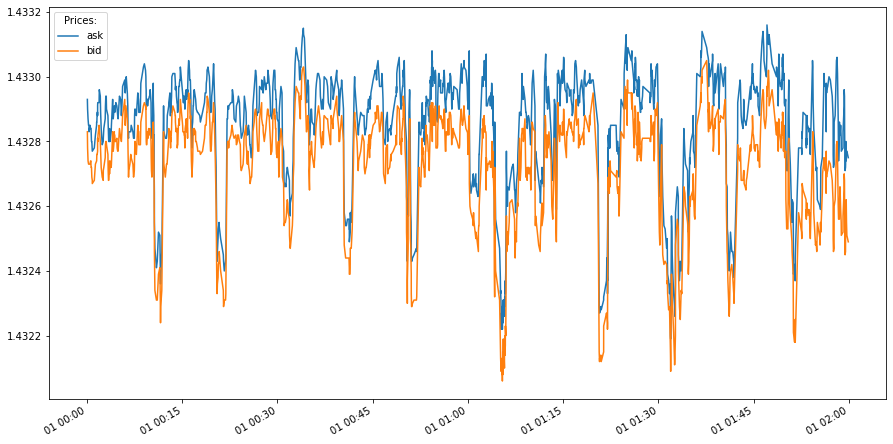

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
plt.rcParams['figure.figsize'] = [15, 8]

def plot_tick_data(df):
    x = df["DateTime"].values
    bid = df["Bid"].values
    ask = df["Ask"].values
    volume = df["Volume"].values
    plt.plot(x, ask, label="ask")
    plt.plot(x, bid, label="bid")
    plt.gcf().autofmt_xdate()
    plt.legend(title='Prices:')


kdb.load_quote_table("EURUSD")
first_quote_date = kdb.first_quote_date("EURUSD")
from_date = first_quote_date
to_date = first_quote_date + timedelta(hours=2)
df = kdb.get_quote_data("EURUSD", from_date, to_date)
plot_tick_data(df)
plt.show()